In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import json
import time
import itertools as it
import sys
sys.path.append('lib')
from analysis_utils import *

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

# Todo 
- make PR_type a string for all versions

In [33]:
def combine(*vs):
    def loop():
        first_pid = 0
        for v in vs:
            df = pd.read_csv('data/human/0.{}/mouselab-mdp.csv'.format(v))
            pdf = pd.read_csv('data/human/0.{}/participants.csv'.format(v))
            df.pid += first_pid
            pdf.pid += first_pid
            first_pid += max(pdf.pid.max(), df.pid.max()) + 1
            yield df, pdf
    dfs, pdfs = zip(*loop())
    df = pd.concat(dfs).reset_index()
    pdf = pd.concat(pdfs).reset_index().set_index('pid', drop=False)
    return df, pdf

def load(v):
    df = pd.read_csv('data/human/{}/mouselab-mdp.csv'.format(v))
    pdf = pd.read_csv('data/human/{}/participants.csv'.format(v))
    return df, pdf

df, pdf = load('1B.0')

completed = list(pdf.query('completed').pid)
df = df.query('pid == @completed')
pdf = pdf.query('pid == @completed')

df.trial_index = df.trial_index.astype(int)
df.trial_i = df.trial_i.astype(int)
df['version'] = list(pdf.version.loc[df.pid])
df['info_cost'] = list(pdf.info_cost.loc[df.pid])
df['PR_type'] = list(pdf.PR_type.loc[df.pid])
df['message'] = list(pdf.message.loc[df.pid])


from toolz.curried import *
from ast import literal_eval
df.queries = df.queries.apply(literal_eval)
df['clicks'] = df.queries.apply(
    lambda x: lmap(int, x['click']['state']['target'])
)
df['click_times'] = df.queries.apply(
    lambda x: x['click']['state']['time']
)
df.action_times = df.action_times.apply(literal_eval)
df['n_click'] = df.clicks.apply(len)
df.delays = df.delays.apply(literal_eval)
df.path = df.path.apply(
    lambda x: [1] + literal_eval(x)[1:])

pdf['time'] = df.groupby('pid').time_elapsed.max() / 60000
pdf['score'] = df.groupby('pid').score.sum()

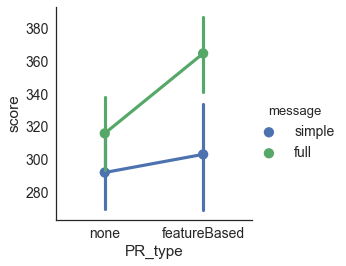

In [59]:
sns.factorplot('PR_type', 'score', hue='message', data=pdf)

In [36]:
df.query('PR_type == "featureBased"').groupby('info_cost').delays.apply(
    lambda ds: np.stack(ds).mean(0).round().astype(int)
)

info_cost
0.01    [2, 0, 0]
1.00    [4, 1, 1]
2.50    [6, 0, 1]
Name: delays, dtype: object

In [37]:
# sys.path.append('bin')
# from compensation import Compensator
# comp = Compensator()
# for v in range(1, 6):
#     identifiers = pd.read_csv('data/human_raw/0.{}/identifiers.csv'.format(v))
#     pdf = pd.read_csv('data/human/0.{}/participants.csv'.format(v))
#     pdf = pdf.join(identifiers.set_index('pid'))
#     for i, row in pdf.iterrows():
#         comp.approve(row.assignment_id)
#         if row.bonus > 0:
#             comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))

In [38]:
# def before_first(row):
#     try:
#         a1 = row.action_times[0]
#         return sum(1 for ct in row.click_times if ct < a1)
#     except:
#         return None

# df['early_click'] = df.apply(before_first, axis=1).astype(int)

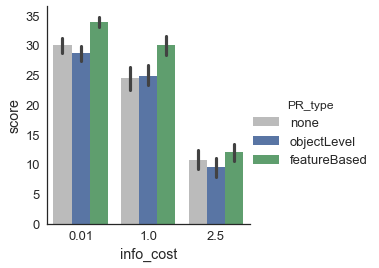

In [39]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = 'none objectLevel featureBased'.split()
# PR_ORDER = ['objectLevel', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df, 
               kind='bar', hue_order=PR_ORDER)

In [57]:
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

array([[40, 54],
       [16, 54],
       [54, 54],
       ..., 
       [34, 54],
       [34, 54],
       [19, 54]])

In [58]:
INFO_COSTS = [0.01, 1.00, 2.50]
# INFO_COSTS = pdf.info_cost.unique()
dd = df.copy()
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

df['optimal'] = comparison('optimal')
df['worst'] = comparison('worst')

# df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal
df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

# (R-R_min)/(R_max-R_min)
df['relative_score'] = (df.score - df.worst) / (df.optimal - df.worst)

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Exception: cannot handle a non-unique multi-index!

In [66]:
cols = ('pid info_cost PR_type message trial_index trial_i delays '
        'score n_click clicks click_times path action_times'
        .split())
df[cols].to_csv('data/human/1B.0/trials.csv')

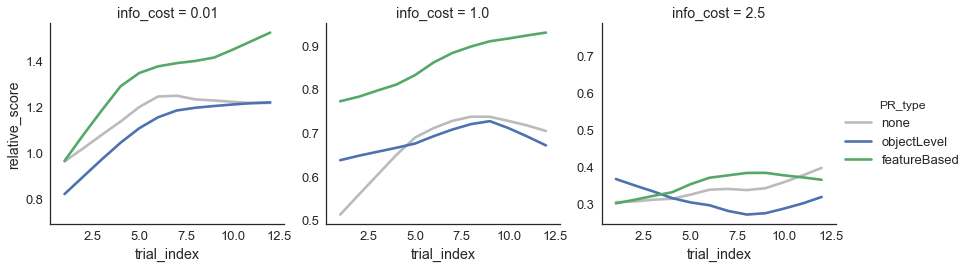

In [43]:
sns.lmplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False, lowess=True, scatter=0,
               hue_order=PR_ORDER, palette=PALETTE)

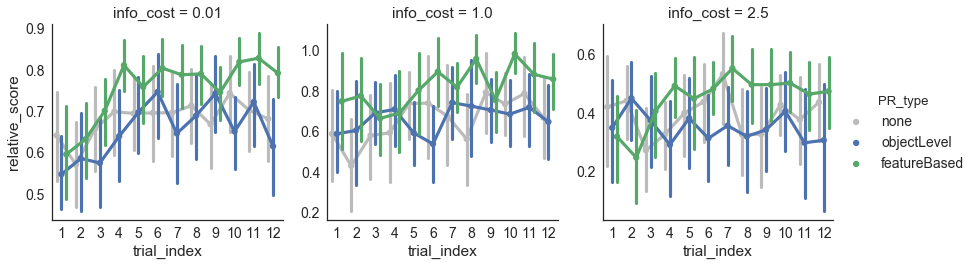

In [27]:
sns.factorplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False,
               dodge=.5, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

In [13]:
rdf = df2r(df, 
           ['info_cost', 'relative_score', 'trial_index', 'score', 'n_click', 'pid', 'trial_i', 'PR_type'])

In [26]:
%%R -i rdf
require(lme4)
require(car)
require(lsmeans)
# rdf$info_cost = as.factor(rdf$info_cost)
m = Anova(lmer('relative_score ~ trial_index * PR_type * info_cost + (1|pid) + (1|trial_i)', 
          test.statistic="F",
          data=rdf,
           # data=subset(rdf, info_cost == .01)
                      ))
m

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: relative_score
                                 Chisq Df Pr(>Chisq)    
trial_index                    28.6083  1   8.86e-08 ***
PR_type                        17.4137  2  0.0001655 ***
info_cost                     122.7093  1  < 2.2e-16 ***
trial_index:PR_type             6.4545  2  0.0396671 *  
trial_index:info_cost           2.6679  1  0.1023916    
PR_type:info_cost               0.2882  2  0.8658105    
trial_index:PR_type:info_cost   1.6834  2  0.4309820    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [238]:
%%R -i rdf
summary(lm('score ~ info_cost * trial_index * PR_type', 
           data=subset(rdf, info_cost > 0)
                      ))


Error in eval(expr, envir, enclos) : object 'PR_type' not found


In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55
